# Chapter 3 - Training process and learning rate
In this chapter we will clean up our code and create a logistic classifier class that works much like many modern deep learning libraries do. We will also have a closer look at our first hyper parameter, the learning rate alpha.

In [1]:
# Numpy handles matrix multiplication, see http://www.numpy.org/
import numpy as np
# PyPlot is a matlab like plotting framework, see https://matplotlib.org/api/pyplot_api.html
import matplotlib.pyplot as plt
# This line makes it easier to plot PyPlot graphs in Jupyter Notebooks
%matplotlib inline

In [2]:
import sklearn
import sklearn.datasets
import matplotlib
# Slightly larger plot rendering
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## The regressor class
Let's jump straight into the code. In this chapter, we will create a python class for our logistic regressor. If you are unfamiliar with classes in python, check out [Jeff Knup's blogpost](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) for a nice overview. Read the code below carefully, we will deconstruct the different functions afterwards

In [3]:
class LogisticRegressor:
    # Here we are just setting up some placeholder variables
    # This is the dimensionality of our input, that is how many features our input has
    input_dim = 0
    # This is the learning rate alpha
    learning_rate = 0.1
    # We will store the parameters of our model in a dictionary
    model = {}
    # The values calculated in the forward propagation will be stored in this dictionary
    cache = {}
    # The gradients that we calculate during back propagation will be stored in a dictionary
    gradients = {}
    
    # Init function of the class
    def __init__(self,input_dim, learning_rate):
        '''
        Assigns the given hyper parameters and initializes the initial parameters.
        '''
        # Assign input dimensionality 
        self.input_dim = input_dim
        # Assign learning rate
        self.learning_rate = learning_rate
        # Trigger parameter setup
        self.init_parameters()
    
    # Parameter setup function
    def init_parameters(self):
        '''
        Initializes weights with random number between -1 and 1
        Initializes bias with 0
        Assigns weights and parameters to model
        '''
        # Randomly init weights
        W1 = 2*np.random.random((self.input_dim,1)) - 1
        # Set bias to 0
        b1 = 0
        # Assign to model
        self.model = {'W1':W1,'b1':b1}
        return
    
    
    # Sigmoid function
    def sigmoid(self,x):
        '''
        Calculates the sigmoid activation of a given input x
        See: https://en.wikipedia.org/wiki/Sigmoid_function
        '''
        return 1/(1+np.exp(-x))

    #Log Loss function
    def log_loss(self,y,y_hat):
        '''
        Calculates the logistic loss between a prediction y_hat and the labels y
        See: http://wiki.fast.ai/index.php/Log_Loss
        
        We need to clip values that get too close to zero to avoid zeroing out. 
        Zeroing out is when a number gets so small that the computer replaces it with 0.
        Therefore, we clip numbers to a minimum value.
        '''
        
        minval = 0.000000000001
        m = y.shape[0]
        l = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)) + (1-y) * np.log((1-y_hat).clip(min=minval)))
        return l

    # Derivative of log loss function
    def log_loss_derivative(self,y,y_hat):
        '''
        Calculates the gradient (derivative) of the log loss between point y and y_hat
        See: https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
        '''
        return (y_hat-y)

    # Forward prop (forward pass) function    
    def forward_propagation(self,A0):
        '''
        Forward propagates through the model, stores results in cache.
        See: https://stats.stackexchange.com/questions/147954/neural-network-forward-propagation
        A0 is the activation at layer zero, it is the same as X
        '''
        # Load parameters from model
        W1, b1 = self.model['W1'],self.model['b1']
        # Do the linear step
        z1 = A0.dot(W1) + b1

        #Pass the linear step through the activation function
        A1 = self.sigmoid(z1)
        # Store results in cache
        self.cache = {'A0':X,'z1':z1,'A1':A1}
        return
    
    # Backprop function
    def backward_propagation(self,y):
        '''
        Backward propagates through the model to calculate gradients.
        Stores gradients in grads dictionary.
        See: https://en.wikipedia.org/wiki/Backpropagation
        '''
        # Load results from forward pass
        A0, z1, A1 = self.cache['A0'],self.cache['z1'], self.cache['A1']
        # Load model parameters
        W1, b1 = self.model['W1'], self.model['b1']
        
        # Read m, the number of examples
        m = A0.shape[0]
        # Calculate the gradient of the loss function
        dz1 = self.log_loss_derivative(y=y,y_hat=A1)
        # Calculate the derivative of the loss with respect to the weights W1
        dW1 = 1/m*(A0.T).dot(dz1)
        # Calculate the derivative of the loss with respect to the bias b1
        db1 = 1/m*np.sum(dz1, axis=0, keepdims=True)
        
        #Make sure the weight derivative has the same shape as the weights
        assert(dW1.shape == W1.shape)
        
        # Store gradients in gradient dictionary
        self.grads = {'dW1':dW1,'db1':db1}
        return
    
    # Parameter update
    def update_parameters(self):
        '''
        Updates parameters accoarding to gradient descent algorithm
        See: https://en.wikipedia.org/wiki/Gradient_descent
        '''
        # Load model parameters
        W1, b1 = self.model['W1'],self.model['b1']
        # Load gradients
        dW1, db1 = self.grads['dW1'], self.grads['db1']
        # Update weights
        W1 -= self.learning_rate * dW1
        # Update bias
        b1 -= self.learning_rate * db1
        # Store new parameters in model dictionary
        self.model = {'W1':W1,'b1':b1}
        return
    
    # Prediction function
    def predict(self,X):
        '''
        Predicts y_hat as 1 or 0 for a given input X
        '''
        # Do forward pass
        self.forward_propagation(X)
        # Get output of regressor
        regressor_output = self.cache['A1']
        
        # Turn values to either 1 or 0
        regressor_output[regressor_output > 0.5] = 1
        regressor_output[regressor_output < 0.5] = 0
        
        # Return output
        return regressor_output
    # Train function
    def train(self,X,y, epochs):
        '''
        Trains the regressor on a given training set X, y for the specified number of epochs.
        '''
        # Set up array to store losses
        losses = []
        # Loop through epochs
        for i in range(epochs):
            # Forward pass
            self.forward_propagation(X)
            
            # Calculate loss
            loss = self.log_loss(y,self.cache['A1'])
            # Store loss
            losses.append(loss)
            # Print loss every 10th iteration
            if (i%10 == 0):
                print('Epoch:',i,' Loss:', loss)
            
            # Do the backward propagation
            self.backward_propagation(y)
            # Update parameters
            self.update_parameters()
        # Return losses for analysis
        return losses

## Using the regressor
To use the regressor, we define an instance of the class and can then train it. Here we will use the same data as in chapter 2.

In [4]:
#Seed the random function to ensure that we always get the same result
np.random.seed(1)

#Variable definition

#define X
X = np.array([[0,1,0],
              [1,0,0],
              [1,1,1],
              [0,1,1]])
#define y
y = np.array([[0,1,1,0]]).T

# Define instance of class
regressor = LogisticRegressor(input_dim=3,learning_rate=1)

In [5]:
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 0.8223225820877986
Epoch: 10  Loss: 0.33146603610936654
Epoch: 20  Loss: 0.19471850517489514
Epoch: 30  Loss: 0.13553540586737906
Epoch: 40  Loss: 0.10339505099570231
Epoch: 50  Loss: 0.08341167129089978
Epoch: 60  Loss: 0.0698444800250881
Epoch: 70  Loss: 0.06005195840562183
Epoch: 80  Loss: 0.052659724538326486
Epoch: 90  Loss: 0.04688538611053053


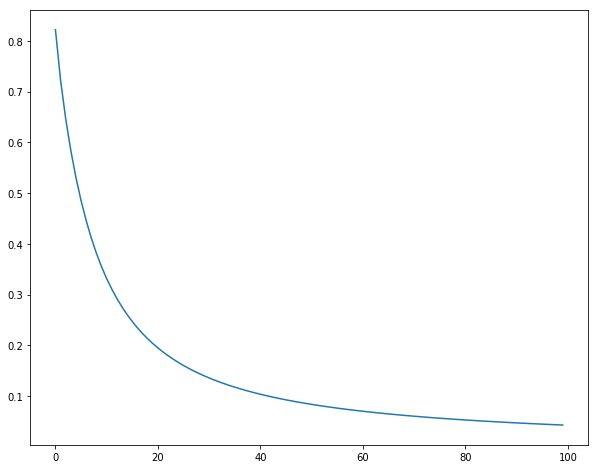

In [6]:
# Plot the losses for analyis
plt.plot(losses)

## Revisiting the training process
As you can see, our classifier still works! We have improved modularity and created an easier to debug classifier. Let's have a look at its overall structure. As you can see, we make use of three dictionaries:
- model: Stores the model parameters, weights and bias
- cache: Stores all intermediate results from the forward pass. These are needed for the backward propagation
- grads: Stores the gradients from the backward propagation

These dictionaries store all information required to run the training process:

![Training Process](https://storage.googleapis.com/aibootcamp/Week%201/assets/training_process.jpg)

We run this process many times over. One full cycle done with the full training set is called an epoch. How often we have to go through this process can vary, depending on the complexity of the problem we want to solve and the learning rate $\alpha$. You see alpha being used in the code above already so let's give it a closer look.

## What is the learning rate anyway?
The learning rate is a lot like the throttle setting in our learning algorithm. It is the multiplier to the update the parameter experiences. 

$$a := a - \alpha * \frac{dL(w)}{da}$$

A high learning rate means that the parameters get updated by larger amounts. This can lead to faster training, but it can also mean that we might jump over a minimum.

![Learning Rate](https://storage.googleapis.com/aibootcamp/Week%201/assets/learning_rate.jpg)

As you can see with a bigger learning rate we are approaching the minimum much faster. But as we get close, our steps are too big and we are skipping over it. This can even lead to our loss going up over time.

![Divergence](https://storage.googleapis.com/aibootcamp/Week%201/assets/divergence.jpg)

Choosing the right learning rate is therefore crucial. Too small and our learning algorithm might be too slow. Too high and it might fail to converge at a minimum. So in the next step, we will have a look at how to tune this hyper parameter.

## A slightly harder problem
So far we have worked with a really simple dataset in which one input feature is perfectly correlated with the labels $y$. Now we will look at a slightly harder problem.

We generate a dataset of two point clouds and we want to train our regressor on separating them. The data generation is done with sklearn's [dataset generator](http://scikit-learn.org/stable/datasets/index.html#sample-generators).

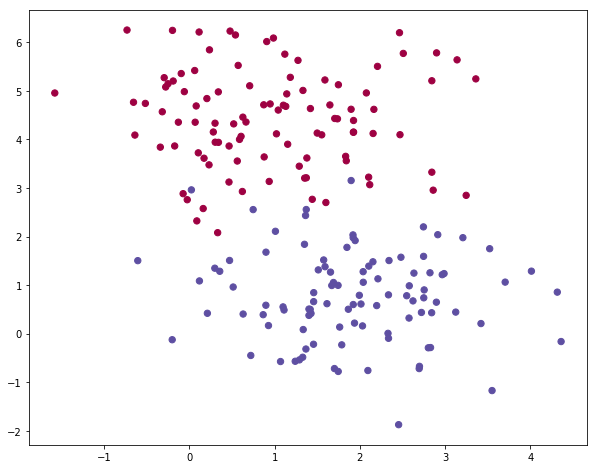

In [7]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_blobs(n_samples=200,centers=2)
y = y.reshape(200,1)
plt.scatter(X[:,0], X[:,1], s=40, c=y.flatten(), cmap=plt.cm.Spectral)

Looking at the data we see that it is possible to separate the two clouds quite well, but there is a lot of noise so we can not hope to achieve zero loss. But we can get close to it. Let's set up a regressor. Here we will use a learning rate of 10, which is quite high.

In [8]:
# Define instance of class
# Learning rate = 1, same as no learning rate used
regressor = LogisticRegressor(input_dim=2,learning_rate=10)

In [9]:
# Train classifier

losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 1.1472166390285021
Epoch: 10  Loss: 0.1893629122235122
Epoch: 20  Loss: 0.08634167640455981
Epoch: 30  Loss: 0.07408059213476534
Epoch: 40  Loss: 0.22083424646673838
Epoch: 50  Loss: 0.10972880172974807
Epoch: 60  Loss: 0.07272731082657073
Epoch: 70  Loss: 0.06785069871312423
Epoch: 80  Loss: 0.06756134729847699
Epoch: 90  Loss: 0.06754774686432065


You will probably even get an error message mentioning an overflow and it doesn't look like the regressor converged smoothly. This was a bumpy ride.

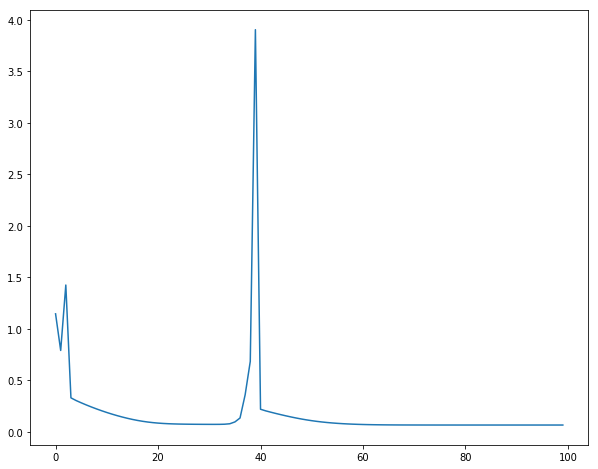

In [10]:
plt.plot(losses)

As you can see, the loss first went _up_ quite significantly before then coming down. At multiple instances it moves up again. This is a clear sign that the learning rate is too large, let's try a lower one

In [11]:
# Define instance of class
# Learning rate = 0.05
regressor = LogisticRegressor(input_dim=2,learning_rate=0.05)

In [12]:
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 1.0516351373290993
Epoch: 10  Loss: 0.7485307809101308
Epoch: 20  Loss: 0.5554183566895117
Epoch: 30  Loss: 0.442581598956324
Epoch: 40  Loss: 0.3750647200336464
Epoch: 50  Loss: 0.3316594679976586
Epoch: 60  Loss: 0.3017540924457521
Epoch: 70  Loss: 0.2799747516771869
Epoch: 80  Loss: 0.2634143598419522
Epoch: 90  Loss: 0.250388739874218


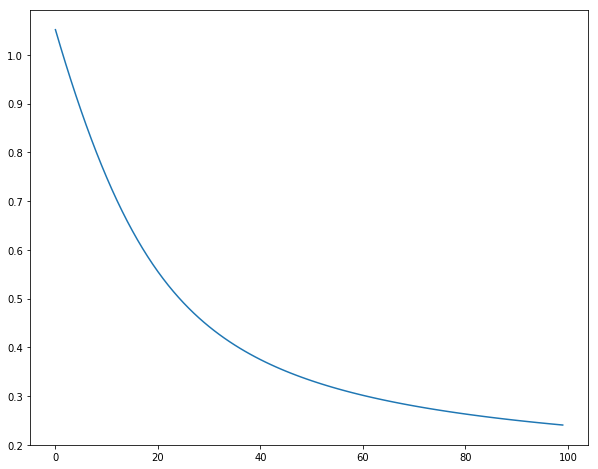

In [13]:
plt.plot(losses)

This looks a bit smoother already, and you can see that the error is nearly ten times lower in the end. Let's try an even lower learning rate to see where we can take this.

In [14]:
# Define instance of class
# Learning rate = 0.0005
regressor = LogisticRegressor(input_dim=2,learning_rate=0.0005)

In [15]:
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 0.5779926337482691
Epoch: 10  Loss: 0.5715444381731928
Epoch: 20  Loss: 0.5652511253360638
Epoch: 30  Loss: 0.5591091818698135
Epoch: 40  Loss: 0.5531151365913389
Epoch: 50  Loss: 0.5472655631505878
Epoch: 60  Loss: 0.5415570823933954
Epoch: 70  Loss: 0.5359863644525714
Epoch: 80  Loss: 0.5305501305818054
Epoch: 90  Loss: 0.5252451547469081


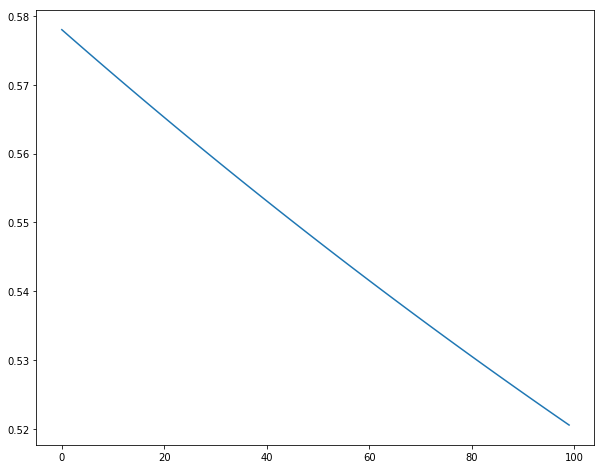

In [16]:
plt.plot(losses)

This is a very smooth gradient descent but also a very slow one. The error is more than twice as high as before in the end. If we would let this run for a few more epochs we probably could achieve a very good model but at a very large computing expense.

## How to find a good value for the learning rate
A good learning rate converges fast and leads to low loss. But there is no silver bullet perfect learning rate that always works. It usually depends on your project. It is as much art as it is science to tune the learning rate and only repeated experimentation can lead you to a good result. Experience shows however, that a good learning rate is usually around 0.1, even though it can well be different for other projects.
To practice tuning the learning rate, play around with the example below and see whether you can find an appropriate one that converges fast and at a low loss. 

In [17]:
# Define instance of class
# Tweak learning rate here
regressor = LogisticRegressor(input_dim=2,learning_rate=1)

In [18]:
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 0.2952540460939577
Epoch: 10  Loss: 0.19058263920284904
Epoch: 20  Loss: 0.16742638592444067
Epoch: 30  Loss: 0.15356402302469085
Epoch: 40  Loss: 0.14336655025400047
Epoch: 50  Loss: 0.13526539358871814
Epoch: 60  Loss: 0.1285926579970743
Epoch: 70  Loss: 0.12298249548223
Epoch: 80  Loss: 0.11820037413891528
Epoch: 90  Loss: 0.11408098660627085


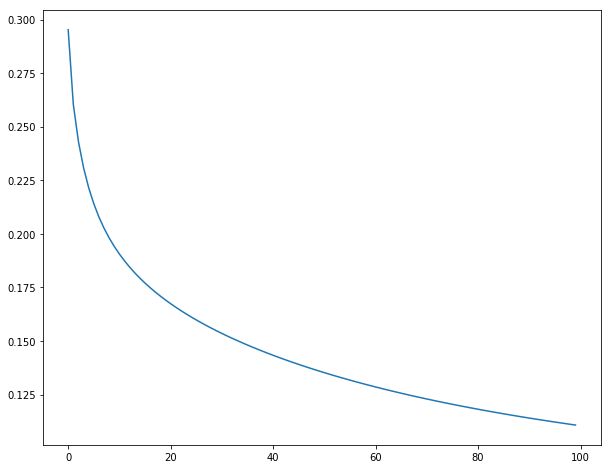

In [19]:
plt.plot(losses)

## Visualizing our regressor
In the last part of this chapter, I would like to give a closer look at what our regressor actually does. To do so, we will plot the decision boundary, that is the boundary the regressor assigns between the two classes.

In [20]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the boundary plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral)

To plot the boundary, we train a new regressor first.

In [21]:
# Define instance of class
# Learning rate = 0.05
regressor = LogisticRegressor(input_dim=2,learning_rate=0.05)
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 0.806070341098119
Epoch: 10  Loss: 0.591334975553595
Epoch: 20  Loss: 0.46530931879853915
Epoch: 30  Loss: 0.3908143441997434
Epoch: 40  Loss: 0.3435810649412854
Epoch: 50  Loss: 0.31139542649121194
Epoch: 60  Loss: 0.2881487559264379
Epoch: 70  Loss: 0.2705823121976358
Epoch: 80  Loss: 0.2568307665145674
Epoch: 90  Loss: 0.2457584391518926


And then we plot the boundary. Again, do not worry if you do not understand exactly what is going on here, as it is not part of the class.

Text(0.5,1,'Decision Boundary for logistic regressor')

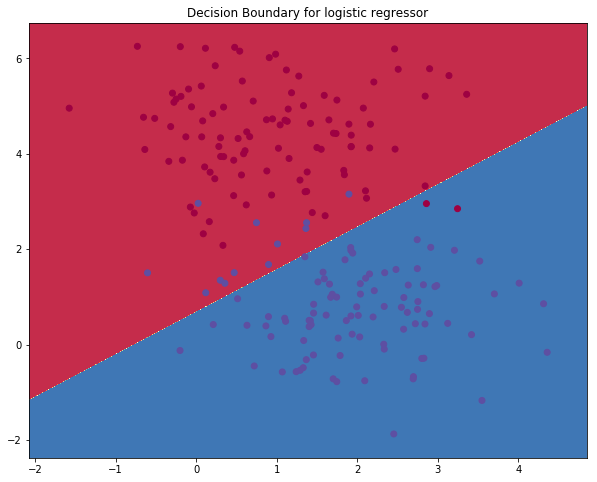

In [22]:
# Plot the decision boundary
plot_decision_boundary(lambda x: regressor.predict(x))
plt.title("Decision Boundary for logistic regressor")

As you can see, our logistic regressor seperates the two clouds with a simple line. This is appropriate for this case but might fail when the boundary is a more complex function. Let's try out a more complex function.

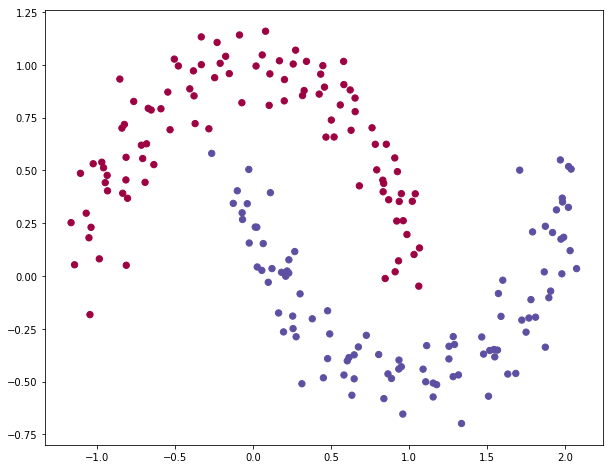

In [23]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.1)
y = y.reshape(200,1)
plt.scatter(X[:,0], X[:,1], s=40, c=y.flatten(), cmap=plt.cm.Spectral)

In [24]:
# Define instance of class
# Learning rate = 0.05
y = y.reshape(200,1)
regressor = LogisticRegressor(input_dim=2,learning_rate=0.05)
# Train classifier
losses = regressor.train(X,y,epochs=100)

Epoch: 0  Loss: 0.4963885415224003
Epoch: 10  Loss: 0.4814375897020179
Epoch: 20  Loss: 0.46832680249603725
Epoch: 30  Loss: 0.45674734114113974
Epoch: 40  Loss: 0.44645338045710475
Epoch: 50  Loss: 0.43724720529503713
Epoch: 60  Loss: 0.42896826785106074
Epoch: 70  Loss: 0.4214850532511196
Epoch: 80  Loss: 0.41468895896094427
Epoch: 90  Loss: 0.4084896361130839


Text(0.5,1,'Decision Boundary for hidden layer size 3')

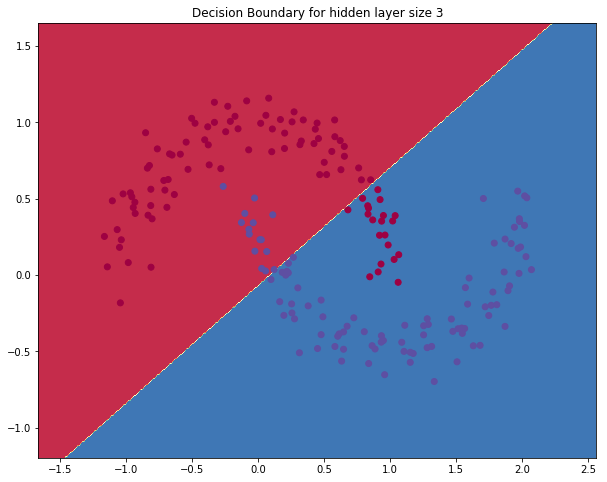

In [25]:
# Plot the decision boundary
plot_decision_boundary(lambda x: regressor.predict(x))
plt.title("Decision Boundary for hidden layer size 3")

Our regressor fails to approximate the more complex function required for this example. In the next chapter we will create a deeper network for this purpose.

## Summary
In this chapter you have seen a refactored version of our logistic regressor from last time. You have seen how data flows through a classifier and seen the training cycle. You have also learned about the learning rate $\alpha$ and how it can affect training. Finally you saw what a logistic regressor does and how it is limited.

## Exercise
In the week 1 folder, you can find an excel sheet called Excel Regressor NN. It is an implementation of a regressor just as we have used it in this chapter. Open it and observe the following:
- How does the forward pass go from data to prediction?
- How do the gradients get computed?
- What happens to the weights over time?
- What happens to the training when you increase or decrease the learning rate? What happens to the weights?